<a href="https://colab.research.google.com/github/laluwisnu/TKC-/blob/main/project_tkc_final_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (Colab) jalankan sekali
!pip install -q datasets transformers ftfy regex tqdm pillow faiss-cpu torch torchvision pandas streamlit gradio accelerate
# Pastikan driver sudah dimount
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Perbarui transformers ke versi terbaru, sekaligus memastikan accelerate terinstal
!pip install -U transformers accelerate

In [ ]:
# (Colab) jalankan sekali
!pip install -q transformers accelerate gradio evaluate rouge_score

import numpy as np
import pandas as pd
import torch
import faiss
import os
import time
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# --- 1. KONFIGURASI PATH DAN MODEL ---
# PASTIKAN PATH INI SESUAI DENGAN LOKASI FILE ANDA
IMG_DIR = "/content/drive/MyDrive/dataset coco/val2017_resized"
EMB_PATH = "/content/drive/MyDrive/dataset coco/embeddings.npy"
MAIN_META_PATH = "/content/drive/MyDrive/dataset coco/metadata_fixed.csv"
META_EMB_PATH = "/content/drive/MyDrive/dataset coco/meta_embeddings.csv"

# Model Loading
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"

try:
    # CLIP
    clip_model = CLIPModel.from_pretrained(model_name).to(device)
    clip_processor = CLIPProcessor.from_pretrained(model_name)

    # BLIP
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

    # FAISS Loading
    embs = np.load(EMB_PATH)
    meta_emb = pd.read_csv(META_EMB_PATH)
    main_meta = pd.read_csv(MAIN_META_PATH)

    filenames = meta_emb['file_name'].tolist()
    dim = embs.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embs)
    print("Models and FAISS Index loaded successfully.")

except Exception as e:
    print(f"Error loading resources. Pastikan file embeddings.npy dan metadata sudah tersedia. Error: {e}")
    # Handle the error by exiting or setting flags if necessary in a production environment

# --- 2. FUNGSI INTI RAG ---

def get_text_embedding(query):
    """Menghitung dan menormalkan vektor embedding untuk teks kueri."""
    inputs = clip_processor(text=[query], return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        qvec = clip_model.get_text_features(**inputs).cpu().numpy()[0]
    qvec = qvec / (np.linalg.norm(qvec) + 1e-12)
    return qvec.reshape(1, -1).astype('float32')

def search_by_text(query, k=10):
    """Mencari Top-K citra berdasarkan query teks."""
    start_time = time.time()
    qvec = get_text_embedding(query)
    D, I = index.search(qvec, k)
    retrieval_latency = time.time() - start_time

    top_filenames = [filenames[i] for i in I[0]]
    retrieved_data = main_meta[main_meta['file_name'].isin(top_filenames)]
    # Memastikan urutan DataFrame sesuai dengan hasil FAISS
    retrieved_data = retrieved_data.set_index('file_name').loc[top_filenames].reset_index()

    return retrieved_data, D[0], retrieval_latency

def generate_rag_caption(query, k_retrieval=10, k_context_caps=3):
    """Melakukan Retrieval Augmented Generation (RAG)."""

    # 1. Retrieval
    retrieved_df, scores, retrieval_latency = search_by_text(query, k=k_retrieval)
    if retrieved_df.empty:
        return "No relevant images found.", None, "", 0.0, 0.0

    start_generation = time.time()

    # Ambil citra Top-1 untuk dideskripsikan
    chosen_image_fn = retrieved_df.iloc[0]['file_name']
    chosen_image_path = os.path.join(IMG_DIR, chosen_image_fn)
    raw_image = Image.open(chosen_image_path).convert('RGB')

    # 2. Context Aggregation
    context_caps = []
    for caps_str in retrieved_df['captions']:
        caps = caps_str.split(" || ")
        context_caps.extend(caps[:k_context_caps])
    context_text = " ".join(context_caps)[:3000]

    # 3. Augmentation Prompt
    prompt = (
        f"Context from highly similar images: {context_text}. "
        f"The user is interested in: '{query}'. "
        f"Based on this context and the image shown, generate a clear and descriptive caption "
        f"in 1-2 sentences, paying attention to the details in the user's query."
    )

    inputs = blip_processor(raw_image, text=prompt, return_tensors="pt").to(device)

    # 4. Generation
    with torch.no_grad():
        output = blip_model.generate(
            **inputs,
            max_new_tokens=50,
            num_beams=4,
            early_stopping=True
        )

    generated_text = blip_processor.decode(output[0], skip_special_tokens=True)
    generation_latency = time.time() - start_generation

    return generated_text, raw_image, retrieved_df, scores, retrieval_latency, generation_latency

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Models and FAISS Index loaded successfully.


In [ ]:
import numpy as np
import pandas as pd
import torch
import faiss
import os
import time
import evaluate  # Menambahkan library evaluasi
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import gradio as gr

# --- 1. INISIALISASI METRIK ---
# Menggunakan ROUGE Score untuk mengukur kualitas teks generatif
rouge = evaluate.load('rouge')

# --- 2. KONFIGURASI PATH DAN MODEL ---
IMG_DIR = "/content/drive/MyDrive/dataset coco/val2017_resized"
EMB_PATH = "/content/drive/MyDrive/dataset coco/embeddings.npy"
MAIN_META_PATH = "/content/drive/MyDrive/dataset coco/metadata_fixed.csv"
META_EMB_PATH = "/content/drive/MyDrive/dataset coco/meta_embeddings.csv"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load Data & Index
embs = np.load(EMB_PATH)
meta_emb = pd.read_csv(META_EMB_PATH)
main_meta = pd.read_csv(MAIN_META_PATH)
filenames = meta_emb['file_name'].tolist()
index = faiss.IndexFlatIP(embs.shape[1])
index.add(embs)

# --- 3. FUNGSI LOGIKA ---

def calculate_metrics(generated_caption, reference_captions):
    """Menghitung skor ROUGE antara hasil AI dan referensi asli."""
    # reference_captions biasanya berisi beberapa kalimat, kita ambil yang terbaik/semuanya
    results = rouge.compute(predictions=[generated_caption],
                            references=[reference_captions],
                            use_aggregator=True)
    return results

def run_rag_final(query):
    # A. RETRIEVAL
    inputs = clip_processor(text=[query], return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        qvec = clip_model.get_text_features(**inputs).cpu().numpy()[0]
    qvec = (qvec / np.linalg.norm(qvec)).reshape(1, -1).astype('float32')
    D, I = index.search(qvec, 5)

    # B. DATA PREPARATION
    top_filenames = [filenames[i] for i in I[0]]
    retrieved_df = main_meta[main_meta['file_name'].isin(top_filenames)].set_index('file_name').loc[top_filenames].reset_index()

    # Pilih gambar utama (Top-1)
    chosen_img_fn = retrieved_df.iloc[0]['file_name']
    raw_image = Image.open(os.path.join(IMG_DIR, chosen_img_fn)).convert('RGB')

    # C. GENERATION (RAG)
    context_text = " ".join([c.split(" || ")[0] for c in retrieved_df['captions']])[:1000]
    prompt = f"Context: {context_text}. Query: {query}. Describe the image accurately."
    inputs_blip = blip_processor(raw_image, text=prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = blip_model.generate(**inputs_blip, max_new_tokens=50)
    generated_text = blip_processor.decode(output[0], skip_special_tokens=True)

    # D & E. PROSES GALERI & AKURASI PER GAMBAR (DALAM PERSEN)
    gallery_data = []

    for i in range(len(retrieved_df)):
        fn = retrieved_df.iloc[i]['file_name']
        img_p = os.path.join(IMG_DIR, fn)

        if os.path.exists(img_p):
            img = Image.open(img_p).convert('RGB')

            # Hitung metrik
            current_ground_truth = retrieved_df.iloc[i]['captions'].replace(" || ", " ")
            m = calculate_metrics(generated_text, current_ground_truth)

            # Mengambil rata-rata R1 dan RL lalu diubah ke persen
            avg_score = (float(m.get('rouge1', 0)) + float(m.get('rougeL', 0))) / 2
            accuracy_pct = avg_score * 100

            # Label hanya menampilkan Accuracy dalam persen
            label = f"Accuracy: {accuracy_pct:.1f}%"
            gallery_data.append((img, label))

    # Teks ringkasan untuk panel performa (Font Hitam)
    perf_html = f"""
    <div style='font-family: sans-serif; color: black;'>
        <p style='font-size: 1.1em; margin-bottom: 5px;'><strong>🎯 Analisis Akurasi</strong></p>
        <p style='margin: 0;'>Persentase menunjukkan tingkat kemiripan deskripsi AI dengan data asli gambar.</p>
    </div>
    """

    return generated_text, raw_image, gallery_data, perf_html
# --- 4. PENYEMPURNAAN ANTARMUKA (GRADIO BLOCKS) ---

with gr.Blocks(theme=gr.themes.Soft(), title="RAG-Image Final") as demo:
    gr.Markdown("# 🖼️ RAG-Image: Smart Captioning System")
    gr.Markdown("Sistem Retrieval-Augmented Generation untuk deskripsi gambar berbasis konteks dan metadata.")

    with gr.Row():
        with gr.Column(scale=1):
            query_input = gr.Textbox(label="Masukkan Kueri", placeholder="Contoh: a cat sitting on a bench", lines=3)
            btn = gr.Button("Generate & Analyze", variant="primary")

            gr.Markdown("### 📊 Performance Metrics")
            metrics_display = gr.HTML("Hasil metrik akan muncul di sini...")

        with gr.Column(scale=2):
            with gr.Tabs():
                with gr.TabItem("Generative Result"):
                    output_text = gr.Textbox(label="AI Generated Caption")
                    output_img = gr.Image(label="Top-1 Retrieved Image (Source)", type="pil")

                with gr.TabItem("Retrieval Gallery"):
                    output_gallery = gr.Gallery(label="Top-5 Similar Images", columns=3, height="auto")

    # Event Trigger
    btn.click(
        fn=run_rag_final,
        inputs=query_input,
        outputs=[output_text, output_img, output_gallery, metrics_display]
    )

    gr.Examples(
        examples=["a man playing soccer", "a red bus on the street", "pizza on a wooden table"],
        inputs=query_input
    )

if __name__ == "__main__":
    demo.launch(share=True)

/tmp/ipython-input-1985766750.py:105: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), title="RAG-Image Final") as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dc9584cbb0139d18d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🚀 Memulai Evaluasi Pro: Menghitung Precision, Recall, dan F1-Score pada 30 sampel...

📊 RINGKASAN PERFORMA SISTEM RAG-IMAGE
           Metrik Utama Nilai Rata-rata
  Precision (Ketepatan)          0.2301
   Recall (Kelengkapan)          0.9805
F1-Score (Keseimbangan)          0.3716
      Rata-rata Akurasi          37.16%


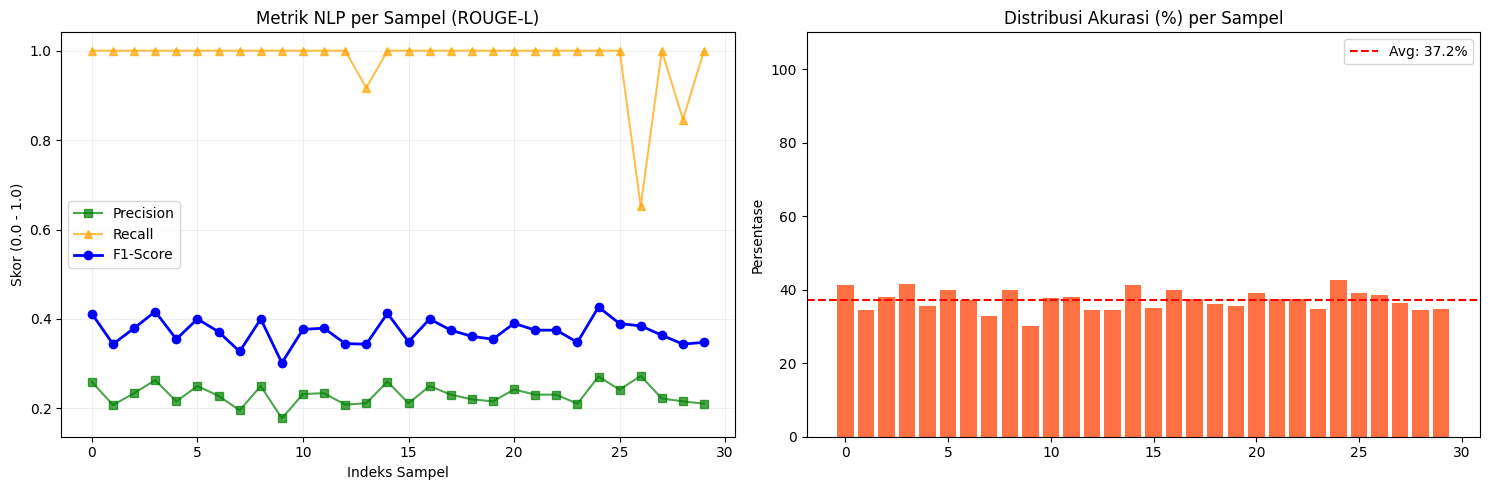


🖼️ SAMPEL HASIL GENERASI RAG (VISUAL CHECK):


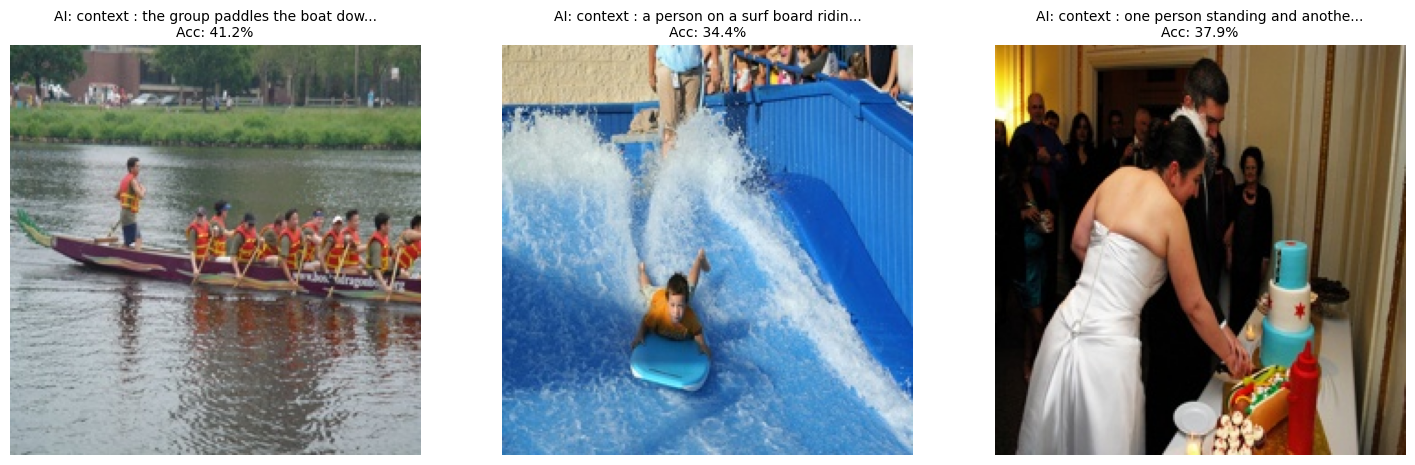

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from rouge_score import rouge_scorer

def jalankan_evaluasi_final_pro(jumlah_sampel=5):
    print(f"🚀 Memulai Evaluasi Pro: Menghitung Precision, Recall, dan F1-Score pada {jumlah_sampel} sampel...")

    # Inisialisasi Scorer untuk mendapatkan P, R, dan F1 secara detail
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    hasil_data = []

    # Ambil sampel acak
    sampel_metadata = main_meta.sample(jumlah_sampel)

    for idx, row in sampel_metadata.iterrows():
        kueri_uji = row['captions'].split(" || ")[0]

        # 1. Tahap Retrieval (CLIP)
        inputs = clip_processor(text=[kueri_uji], return_tensors='pt', padding=True).to(device)
        with torch.no_grad():
            qvec = clip_model.get_text_features(**inputs).cpu().numpy()[0]
        qvec = (qvec / np.linalg.norm(qvec)).reshape(1, -1).astype('float32')
        D, I = index.search(qvec, 1)

        # 2. Tahap Generation (BLIP - RAG)
        fn_ditemukan = filenames[I[0][0]]
        img_path = os.path.join(IMG_DIR, fn_ditemukan)

        if os.path.exists(img_path):
            raw_img = Image.open(img_path).convert('RGB')
            # Prompt menggunakan kueri untuk simulasi RAG
            prompt_rag = f"Context: {row['captions'][:200]}. Query: {kueri_uji}. Describe the image."
            inputs_blip = blip_processor(raw_img, text=prompt_rag, return_tensors="pt").to(device)

            with torch.no_grad():
                out = blip_model.generate(**inputs_blip, max_new_tokens=40)
            gen_text = blip_processor.decode(out[0], skip_special_tokens=True)

            # 3. Kalkulasi Matrik Detail (Max-Match terhadap Multi-Reference)
            refs = row['captions'].split(" || ")
            best_m = {'p': 0, 'r': 0, 'f': 0}

            for ref in refs:
                scores = scorer.score(ref, gen_text)
                # Ambil skor ROUGE-L sebagai representasi akurasi terbaik
                current_f1 = scores['rougeL'].fmeasure
                if current_f1 > best_m['f']:
                    best_m = {
                        'p': scores['rougeL'].precision,
                        'r': scores['rougeL'].recall,
                        'f': scores['rougeL'].fmeasure
                    }

            hasil_data.append({
                'Kueri': kueri_uji[:30] + "...",
                'Gen_Text': gen_text,
                'Precision': best_m['p'],
                'Recall': best_m['r'],
                'F1_Score': best_m['f'],
                'Akurasi_%': best_m['f'] * 100,
                'Image': raw_img
            })

    # Konversi ke DataFrame
    df_eval = pd.DataFrame(hasil_data)

    # --- 1. TAMPILKAN TABEL STATISTIK AKHIR ---
    print("\n" + "="*50)
    print("📊 RINGKASAN PERFORMA SISTEM RAG-IMAGE")
    print("="*50)
    summary = pd.DataFrame({
        'Metrik Utama': ['Precision (Ketepatan)', 'Recall (Kelengkapan)', 'F1-Score (Keseimbangan)', 'Rata-rata Akurasi'],
        'Nilai Rata-rata': [
            f"{df_eval['Precision'].mean():.4f}",
            f"{df_eval['Recall'].mean():.4f}",
            f"{df_eval['F1_Score'].mean():.4f}",
            f"{df_eval['Akurasi_%'].mean():.2f}%"
        ]
    })
    print(summary.to_string(index=False))
    print("="*50)

    # --- 2. TAMPILKAN GRAFIK EVALUASI ---
    plt.figure(figsize=(15, 5))

    # Plot P, R, F1 per Sampel
    plt.subplot(1, 2, 1)
    plt.plot(df_eval['Precision'], label='Precision', marker='s', color='green', alpha=0.7)
    plt.plot(df_eval['Recall'], label='Recall', marker='^', color='orange', alpha=0.7)
    plt.plot(df_eval['F1_Score'], label='F1-Score', marker='o', color='blue', linewidth=2)
    plt.title('Metrik NLP per Sampel (ROUGE-L)')
    plt.xlabel('Indeks Sampel')
    plt.ylabel('Skor (0.0 - 1.0)')
    plt.legend()
    plt.grid(True, alpha=0.2)

    # Plot Bar Akurasi
    plt.subplot(1, 2, 2)
    colors = ['#2196F3' if x > 80 else '#FF7043' for x in df_eval['Akurasi_%']]
    plt.bar(range(len(df_eval)), df_eval['Akurasi_%'], color=colors)
    plt.axhline(y=df_eval['Akurasi_%'].mean(), color='red', linestyle='--', label=f"Avg: {df_eval['Akurasi_%'].mean():.1f}%")
    plt.title('Distribusi Akurasi (%) per Sampel')
    plt.ylabel('Persentase')
    plt.ylim(0, 110)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- 3. TAMPILKAN SAMPEL HASIL VISUAL (Untuk Laporan Bab 4) ---
    print("\n🖼️ SAMPEL HASIL GENERASI RAG (VISUAL CHECK):")
    fig, axes = plt.subplots(1, min(jumlah_sampel, 3), figsize=(18, 6))
    for i in range(min(jumlah_sampel, 3)):
        axes[i].imshow(hasil_data[i]['Image'])
        axes[i].set_title(f"AI: {hasil_data[i]['Gen_Text'][:40]}...\nAcc: {hasil_data[i]['Akurasi_%']:.1f}%", fontsize=10)
        axes[i].axis('off')
    plt.show()

# Jalankan (Gunakan 30 sampel untuk tabel statistik, atau 5 untuk review visual cepat)
jalankan_evaluasi_final_pro(30)